In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import statsmodels.api as sm

plt.style.use("bmh")

## Neural network optimization

In [115]:
import torch
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [159]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")

data = pd.read_csv(os.path.join(target_path, "betadgp_corrdgp_data.csv"))
y = data["betas_dgp"].values
X = data["corr_dgp"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = torch.FloatTensor(y_train)
X_train = torch.FloatTensor(X_train).unsqueeze(0).t()

y_test = torch.FloatTensor(y_test)
X_test = torch.FloatTensor(X_test).unsqueeze(0).t()

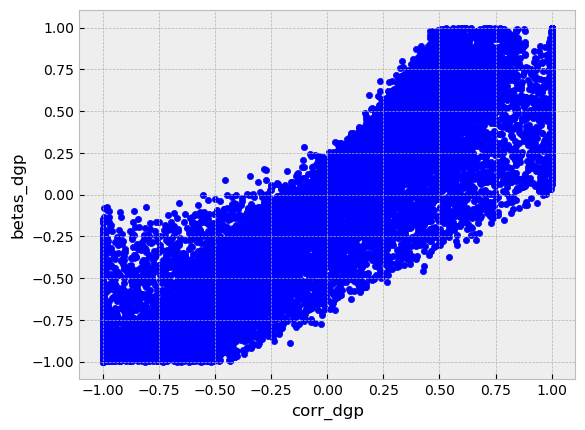

In [160]:
data.plot.scatter(y="betas_dgp", x="corr_dgp")

### 1) Linear regression

In [161]:
linear_reg_model = LinearRegression(fit_intercept=True)
linear_reg_model_train = linear_reg_model.fit(X=X_train, y=y_train)

linear_reg_model_predictions = linear_reg_model_train.predict(X=X_test)
preds_df = pd.DataFrame({'true': y_test, 'prediction': linear_reg_model_predictions})

linear_reg_model_train.coef_

array([0.8393889], dtype=float32)

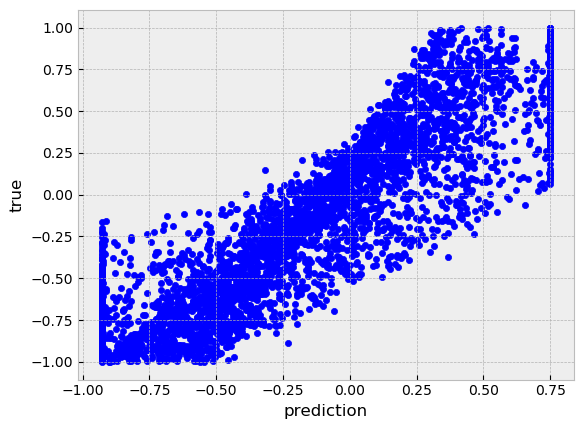

In [162]:
preds_df.plot.scatter(y="true", x="prediction")

In [163]:
print("Linear regression MSE: ", mean_squared_error(y_true=preds_df["true"], y_pred=preds_df["prediction"]))

Linear regression MSE:  0.06277616


Text(0.5, 1.0, 'Linear regression')

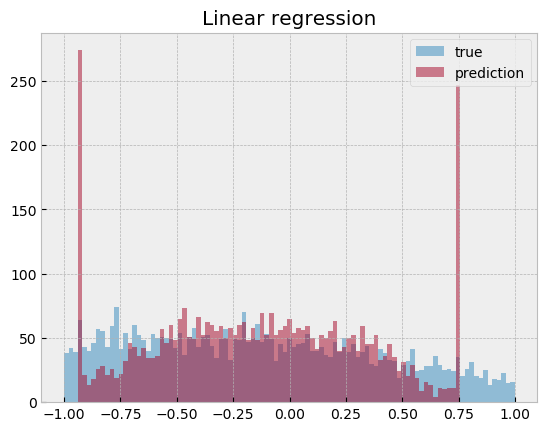

In [164]:
bins = np.linspace(preds_df.min().min(), preds_df.max().max(), 100)
for colname in preds_df.columns:
    plt.hist(preds_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("Linear regression")

In [208]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size, bias):
            super().__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.bias = bias
            
            self.input_layer = torch.nn.Linear(self.input_size, self.hidden_size, bias=self.bias)
            self.relu = torch.nn.ReLU()
            self.hidden_layer = torch.nn.Linear(self.hidden_size, self.hidden_size, bias=self.bias)
            self.output_layer = torch.nn.Linear(self.hidden_size, 1, bias=self.bias)
        def forward(self, x):
            x = self.input_layer(x)
            
            x = self.hidden_layer(x)
            x = self.relu(x)
            x = self.hidden_layer(x)
            x = self.relu(x)
            x = self.hidden_layer(x)
            x = self.relu(x)
                     
            output = self.output_layer(x)
            
            return output
feed_forward_model = Feedforward(input_size=X_train.shape[1], hidden_size=100, bias=True)
feed_forward_model

Feedforward(
  (input_layer): Linear(in_features=1, out_features=100, bias=True)
  (relu): ReLU()
  (hidden_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)

In [214]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(feed_forward_model.parameters(), lr=0.01)

epochs = 10000
loss_arr = []
loss_values = []
for i in tqdm(range(epochs), total=epochs, desc="Running backpropagation"):
    # computer forward prediction
    # if first iter, use random init
    y_hat = feed_forward_model.forward(X_train)

    # computes the loss function
    loss = criterion(y_hat, y_train.unsqueeze(0).t())
    loss_arr.append(loss)
    loss_values.append(loss.item())

    # set all previous gradients to zero
    optimizer.zero_grad()

    # backpropagation
    # computes gradient of current tensor given loss and opt procedure
    loss.backward()
    # update parameters
    optimizer.step()

Running backpropagation: 100%|██████████| 10000/10000 [04:16<00:00, 38.93it/s]


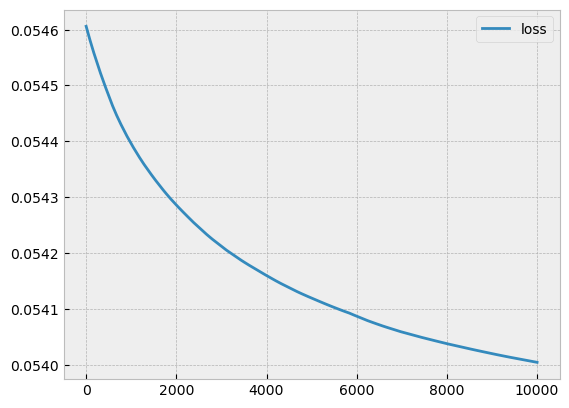

In [215]:
loss_values_df = pd.DataFrame(loss_values, columns=["loss"])
loss_values_df.plot()

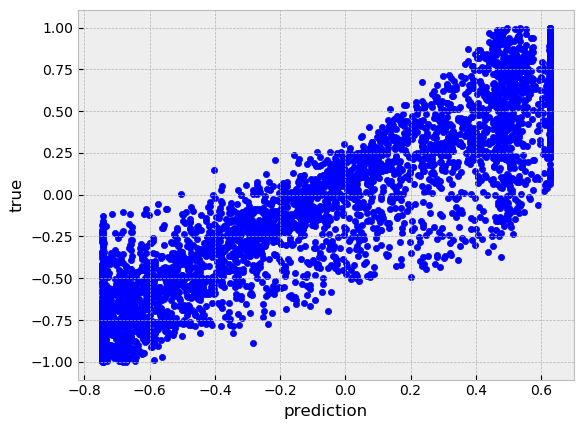

In [216]:
preds = []
with torch.no_grad():
   for val in X_test:
       y_hat = feed_forward_model.forward(val)
       preds.append(y_hat.item())
preds_df = pd.DataFrame({'true': y_test, 'prediction': preds})

preds_df.plot.scatter(y="true", x="prediction")

In [217]:
print("Neural network MSE: ", mean_squared_error(y_true=preds_df["true"], y_pred=preds_df["prediction"]))

Neural network MSE:  0.052880436151070416


Text(0.5, 1.0, 'Neural network')

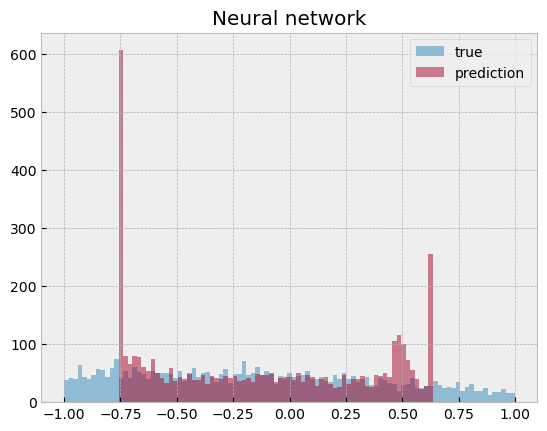

In [218]:
bins = np.linspace(preds_df.min().min(), preds_df.max().max(), 100)
for colname in preds_df.columns:
    plt.hist(preds_df[colname], bins, alpha=0.5, label=colname)
plt.legend(loc='upper right')
plt.title("Neural network")

In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split

class DynamicFeedforward(torch.nn.Module):
        def __init__(self, input_size, n_layers, n_units, bias):
            super().__init__()
            self.input_size = input_size
            self.n_units  = n_units
            self.n_layers = n_layers
            self.bias = bias
            
            self.input_layer = torch.nn.Linear(self.input_size, self.n_units, bias=self.bias)
            self.relu = torch.nn.ReLU()
            self.hidden_layer = torch.nn.Linear(self.n_units, self.n_units, bias=self.bias)
            self.output_layer = torch.nn.Linear(self.n_units, 1, bias=self.bias)
        def forward(self, x):
            x = self.input_layer(x)
            
            for l in range(self.n_layers):
                x = self.hidden_layer(x)
                x = self.relu(x)
                     
            output = self.output_layer(x)
            
            return output

# Build neural network model
def build_model(params):    
    return DynamicFeedforward(input_size=params["input_size"], n_layers=params["n_layers"], n_units=params["n_units"], bias=True)
 
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(param, model, epochs, criterion):
    
    # train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = getattr(torch.optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    loss_arr = []
    loss_values = []
    for i in tqdm(range(epochs), total=epochs, desc="Running backpropagation"):
        # computer forward prediction
        # if first iter, use random init
        y_hat = model.forward(X_train)

        # computes the loss function
        loss = criterion(y_hat, y_train.unsqueeze(0).t())
        loss_arr.append(loss)
        loss_values.append(loss.item())

        # set all previous gradients to zero
        optimizer.zero_grad()

        # backpropagation
        # computes gradient of current tensor given loss and opt procedure
        loss.backward()
        # update parameters
        optimizer.step()
    loss_values_df = pd.DataFrame(loss_values, columns=["loss"])

    preds = []
    for val in X_test:
        y_hat = feed_forward_model.forward(val)
        preds.append(y_hat.item())
    preds_df = pd.DataFrame({'true': y_test, 'prediction': preds})

    preds_df.plot.scatter(y="true", x="prediction")

    return loss_values_df, preds_df
  
 # Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'n_unit': trial.suggest_int("n_unit", 10, 100),
              'n_layers': trial.suggest_int("n_unit", 10, 10),
              'optimizer': trial.suggest_categorical("optimizer", ["SGD"]),
              }
    
     model = build_model(params)
     loss_values, preds = train_and_evaluate(params, model, epochs, criterion)

     return loss_values, preds

In [219]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())

[I 2023-01-21 13:26:51,401] A new study created in memory with name: no-name-963cd6b3-f932-4c5b-ae21-278ec6ce2058


In [ ]:
study.optimize(objective, n_trials=100)

## Simple AR simulation analysis

In [2]:
arparams = np.array([.75, -.25])
ar = np.r_[1, -arparams]
maparams = np.array([0, 0])
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)

sm.tsa.ARIMA(endog=y, order=(2, 0, 0), trend="n").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -334.310
Date:                Mon, 16 Jan 2023   AIC                            674.621
Time:                        07:12:29   BIC                            685.185
Sample:                             0   HQIC                           678.873
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6280      0.064      9.836      0.000       0.503       0.753
ar.L2         -0.1462      0.066     -2.223      0.026      -0.275      -0.017
sigma2         0.8479      0.082     10.369      0.000       0.688       1.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.98   Prob(JB):                         0.77
Heteroskedasticity (H):               0.98   Skew:                             0.05
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Simulate from multiple stationary AR models

In [3]:
alpha = 0.05
i = 0
summary = {}
while i < 10000:

    arparams = np.array([np.random.uniform(low=-1, high=1, size=1)[0], np.random.uniform(low=-1, high=1, size=1)[0]])
    ar = np.r_[1, -arparams]
    maparams = np.array([0, 0])
    ma = np.r_[1, maparams]
    y = sm.tsa.arma_generate_sample(ar, ma, 100)

    if sm.tsa.stattools.adfuller(y)[1] <= alpha:
        summary[i] = {"y": y, "coefs": arparams}
        i += 1

### Compute statistics from simulated data to be used on the prediction taks

In [9]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"betas_dgp": summary[i]["coefs"][l-1], "beta_2x2": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "cov_dgp": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "corr_dgp": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)
corr2x2_df = pd.concat(corr2x2, axis=0)

corr2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_corrdgp_data.csv"), index=False)
cov2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_covdgp_data.csv"), index=False)
betadgp_beta2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_beta2x2_data.csv"), index=False)

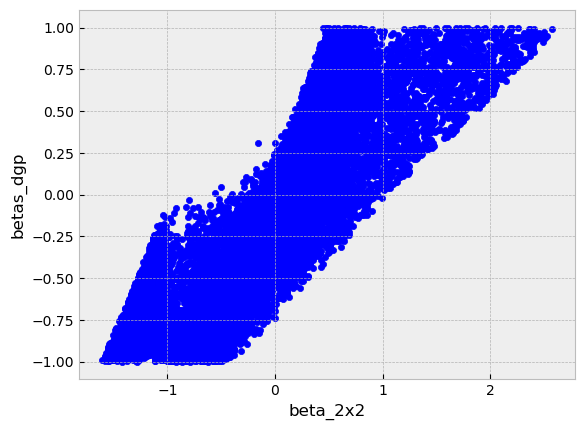

In [10]:
betadgp_beta2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="beta_2x2")

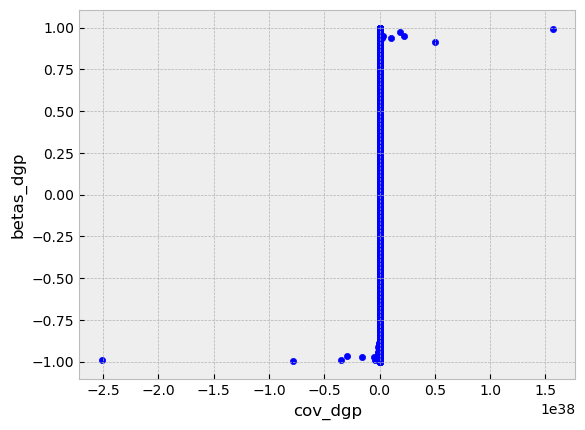

In [11]:
cov2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="cov_dgp")

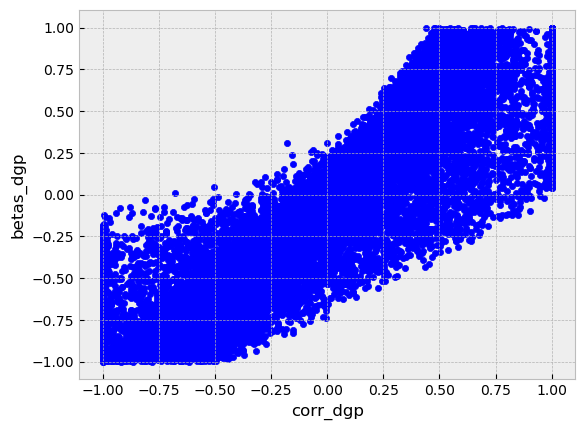

In [12]:
corr2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="corr_dgp")

In [22]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"betas_dgp": summary[i]["coefs"][l-1], "beta_2x2": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "cov_dgp": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "corr_dgp": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)
corr2x2_df = pd.concat(corr2x2, axis=0)

corr2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_corrdgp_data_test.csv"), index=False)
cov2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_covdgp_data_test.csv"), index=False)
betadgp_beta2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_beta2x2_data_test.csv"), index=False)